# Investigate the Latent Mismatch

Load data from the data/rot_mnist/rot_mnist.mat

In [101]:
import scipy.io as sio
import numpy as np
import torch
from torch.utils import data
import os
import matplotlib.pyplot as plt
from data.utils import Dataset

In [102]:
fullname = os.path.join('data', "rot_mnist", "rot-mnist.mat")
dataset = sio.loadmat(fullname)

X = np.squeeze(dataset['X'])
if True:
    Y = np.squeeze(dataset['Y'])
    X = X[Y==3,:,:]

N = 500
T = 16
Xtr   = torch.tensor(X[:N],dtype=torch.float32).view([N,T,1,28,28])
Xtest = torch.tensor(X[N:],dtype=torch.float32).view([-1,T,1,28,28])

# Generators
params = {'batch_size': 25, 'shuffle': True, 'num_workers': 2} #25
trainset = Dataset(Xtr)
trainset = data.DataLoader(trainset, **params)
testset  = Dataset(Xtest)
testset  = data.DataLoader(testset, **params)


Load model

In [103]:
import torch
from torch.distributions import MultivariateNormal 
from model.core.dsvpy import DSVGP_Layer
from model.core.flow import Flow
from model.core.distributions import Bernoulli, Gaussian
from model.core.vae import Encoder, Decoder
from model.core.odegpvae import ODEGPVAE

In [104]:
odegpvae_empty = ODEGPVAE(flow=Flow(diffeq=DSVGP_Layer(D_in=8*2, D_out=8, M=100, S=256,dimwise=True, q_diag=False), solver='euler', use_adjoint=False),
                        enc_s =  Encoder(steps= 1),
                        enc_v = Encoder(steps = 5),
                        decoder = Decoder(),
                        num_observations= 25 * 16, #TODO N*T*D
                        likelihood=Bernoulli(),
                        prior =  MultivariateNormal(torch.zeros(8*2).to('cpu'),torch.eye(8*2).to('cpu')) ,
                        prior_q= MultivariateNormal(torch.zeros(8).to('cpu'),torch.eye(8).to('cpu')) ,
                        ts_dense_scale=2,
                        beta=1,
                        steps=5)
odegpvae_500 = ODEGPVAE(flow=Flow(diffeq=DSVGP_Layer(D_in=8*2, D_out=8, M=100, S=256,dimwise=True, q_diag=False), solver='euler', use_adjoint=False),
                        enc_s =  Encoder(steps= 1),
                        enc_v = Encoder(steps = 5),
                        decoder = Decoder(),
                        num_observations= 25 * 16, #TODO N*T*D
                        likelihood=Bernoulli(),
                        prior =  MultivariateNormal(torch.zeros(8*2).to('cpu'),torch.eye(8*2).to('cpu')) ,
                        prior_q= MultivariateNormal(torch.zeros(8).to('cpu'),torch.eye(8).to('cpu')) ,
                        ts_dense_scale=2,
                        beta=1,
                        steps=5)

specify model location

In [105]:
fname = 'results/mnist_11_08_2022-08:59/odegpvae_mnist.pth'
odegpvae_500.load_state_dict(torch.load(fname,map_location=torch.device('cpu')))
odegpvae_500.eval()

ODEGPVAE(
  (flow): Flow(
    (odefunc): ODEfunc(
      (diffeq): DSVGP_Layer(
        (kern): RBF()
        (inducing_loc): Inducing locations parameter with Identity transformation
        (Um): Inducing distribution (mean) parameter with Identity transformation
        (Us_sqrt): Inducing distribution (scale) parameter with Lower cholesky transformation
      )
    )
  )
  (likelihood): Bernoulli()
  (enc_s): Encoder(
    (cnn): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (7): ReLU()
      (8): Flatten()
    )
    (fc1): Linear(in_features=512, out_features=8, bias=True)


## Latent Mismatch Plotting (ODE vs Encoder)

In [106]:
from sklearn.decomposition import PCA

Pass the data through the encoder

In [107]:
#load a minibatch of data 
data_train = next(iter(trainset)) # N,T,nc,d,d
data_test = next(iter(testset)) # N,T,nc,d,d 

In [108]:
[N,T,nc,d,d] = data_train.shape

proceed with training data just for example

## Option 1. Split the latent space of ODE into v and s 

### Extract the ODE latent encoding

In [109]:
def compute_latent(model,data, split=True):
    T=16
    #encode
    z0, logp0 = model.build_encoding(data)
    #compute the dynamics
    zt, _ = model.build_flow(z0, logp0, T, sample=True) #N,T,2q
    if split:
        q=8
        st_mu = zt[:,:,q:] # N,T,q
        vt_mu = zt[:,:,:q] # N,T,q
        return st_mu, vt_mu
    else:
        return zt

In [110]:
st_mu_base, vt_mu_base = compute_latent(odegpvae_empty, data_train) #no training
st_mu_500, vt_mu_500 = compute_latent(odegpvae_500, data_train) #500 epochs

### Extract the Encoder latent encoding

In [112]:
def compute_encoding_s(model,data_train):
    #only take the mean (?)
    s_muT = []
    for t in range(T):
        s_mu, s_logv = model.enc_s(data_train[:,t])
        s_muT.append(s_mu.unsqueeze(0))
    s_muT= torch.cat(s_muT,0).permute([1,0,2]) #N,T,q
    return s_muT

def compute_encoding_v(model,data_train):
    #only take the mean (?)
    v_muT = []
    i=1
    for t in range(T):
        if t <= T - 5: 
            v_mu, v_logv = model.enc_v(torch.squeeze(data_train[:,t:5+t]))
        else: #reloop the beginning of the data
            data_tmp = torch.cat((data_train[:,t:],data_train[:,:i]), dim=1)
            v_mu, v_logv = model.enc_v(torch.squeeze(data_tmp))
            i+=1
        v_muT.append(v_mu.unsqueeze(0))
    v_muT= torch.cat(v_muT,0).permute([1,0,2]) #N,T,q
    return v_muT

position & velocity encoding (by encoders)

In [113]:
st_enc_mu_base = compute_encoding_s(odegpvae_empty, data_train) #no training
st__enc_mu_500 = compute_encoding_s(odegpvae_500, data_train) #500 epochs
vt_enc_mu_base = compute_encoding_v(odegpvae_empty, data_train) #no training
vt__enc_mu_500 = compute_encoding_v(odegpvae_500, data_train) #500 epochs

### Option 1A: Fit a different pca for every time dimension

In [89]:
pca = PCA(n_components=2)

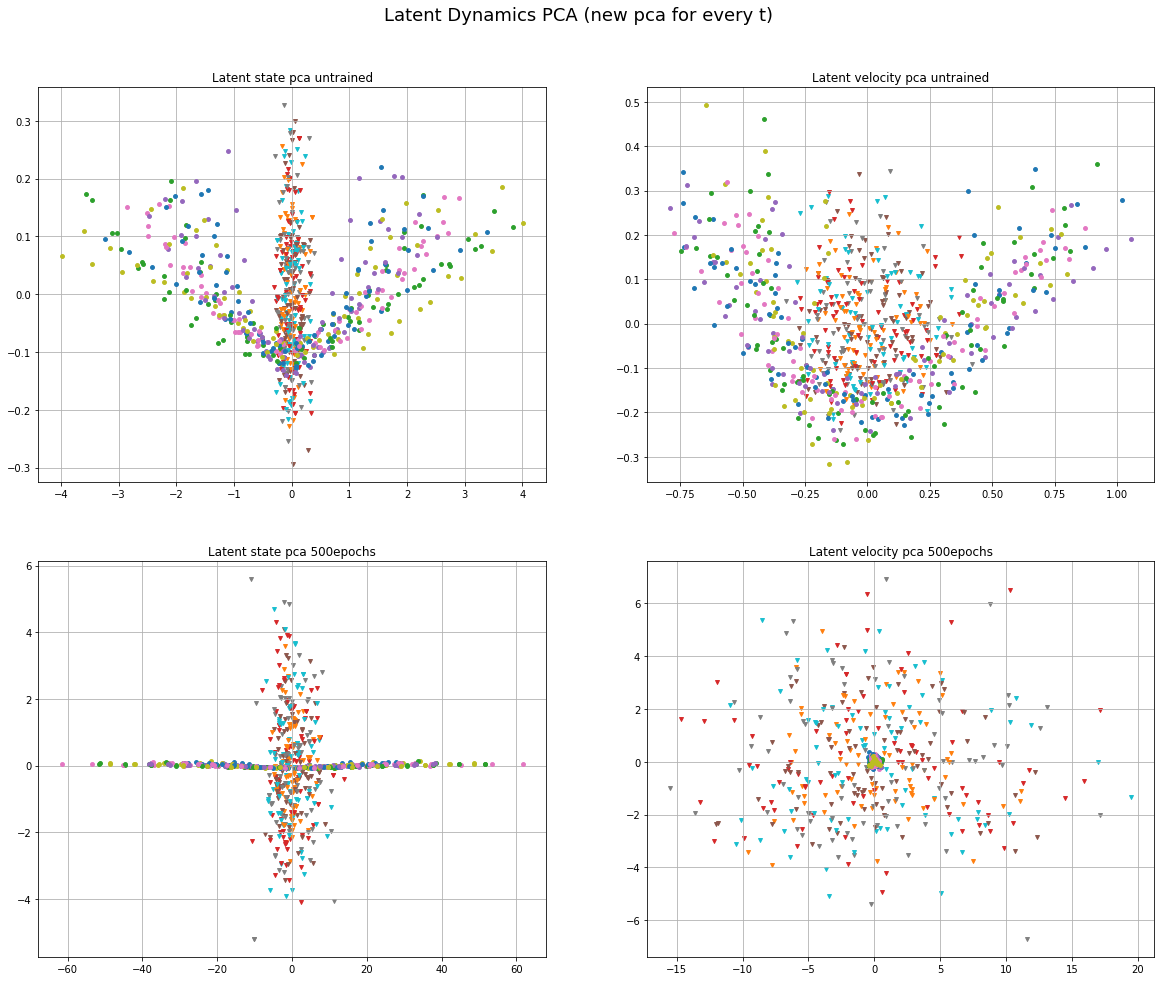

In [135]:
# create subplots
names = ['untrained', '500epochs']
fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(20, 16))
fig.suptitle("Latent Dynamics PCA (new pca for every t)", fontsize=18, y=0.95)
with torch.set_grad_enabled(False):
    for n in range(N):
        for i, data in zip(range(2), ((st_mu_base, st_enc_mu_base, vt_mu_base, vt_enc_mu_base), (st_mu_500, st__enc_mu_500, vt_mu_500, vt__enc_mu_500))):
            data_s_ode, data_s_enc, data_v_ode, data_v_enc = data
            ode_s_pca = pca.fit_transform(data_s_ode[n]) # T,2
            enc_s_pca = pca.fit_transform(data_s_enc[n]) # T,2
            ode_v_pca = pca.fit_transform(data_v_ode[n]) # T,2
            enc_v_pca = pca.fit_transform(data_v_enc[n]) # T,2
            axs[i][0].scatter(ode_s_pca[:,0], ode_s_pca[:,1], s = 15, zorder=2.5)
            axs[i][0].scatter(enc_s_pca[:,0], enc_s_pca[:,1], s=15, marker = 'v')
            axs[i][0].set_title('Latent state pca ' + names[i])
            axs[i][0].grid()

            axs[i][1].scatter(ode_v_pca[:,0],ode_v_pca[:,1], s = 15, zorder=2.5)
            axs[i][1].scatter(enc_v_pca[:,0], enc_v_pca[:,1], s=15, marker = 'v')
            axs[i][1].set_title('Latent velocity pca ' + names[i])
            axs[i][1].grid()
            
plt.show()

### Option 1B: Fit a pca for t=0 reuse for every time dimension

In [136]:
dict_pca = {}
with torch.set_grad_enabled(False): 
    for n, data in zip(range(2), ((st_mu_base, st_enc_mu_base, vt_mu_base, vt_enc_mu_base), (st_mu_500, st__enc_mu_500, vt_mu_500, vt__enc_mu_500))):
        s, s_enc, v, v_enc = data
        dict_pca['pca_{}_s'.format(n)] = PCA(n_components=2).fit(s[:,0])
        dict_pca['pca_{}_s_enc'.format(n)] = PCA(n_components=2).fit(s_enc[:,0])
        dict_pca['pca_{}_v'.format(n)] = PCA(n_components=2).fit(v[:,0])
        dict_pca['pca_{}_v_enc'.format(n)] = PCA(n_components=2).fit(v_enc[:,0])

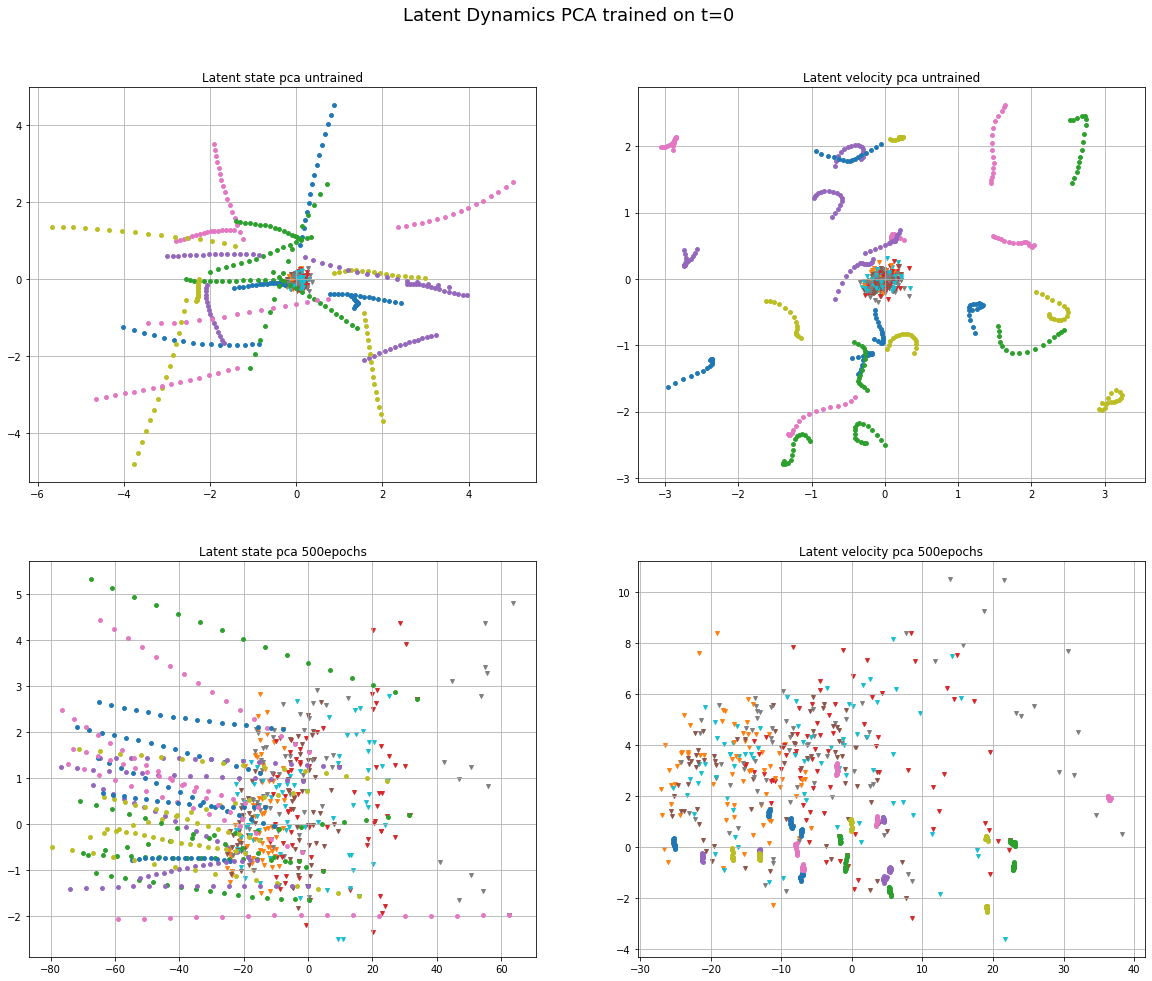

In [137]:
# create subplots
names = ['untrained', '500epochs']
fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(20, 16))
fig.suptitle("Latent Dynamics PCA trained on t=0", fontsize=18, y=0.95)
with torch.set_grad_enabled(False):
    for n in range(N):
        for i, data in zip(range(2), ((st_mu_base, st_enc_mu_base, vt_mu_base, vt_enc_mu_base), (st_mu_500, st__enc_mu_500, vt_mu_500, vt__enc_mu_500))):
            data_s_ode, data_s_enc, data_v_ode, data_v_enc = data
            ode_s_pca = dict_pca['pca_{}_s'.format(i)].transform(data_s_ode[n]) # T,2
            enc_s_pca = dict_pca['pca_{}_s_enc'.format(i)].transform(data_s_enc[n]) # T,2
            ode_v_pca = dict_pca['pca_{}_v'.format(i)].transform(data_v_ode[n]) # T,2
            enc_v_pca = dict_pca['pca_{}_v_enc'.format(i)].transform(data_v_enc[n]) # T,2

            axs[i][0].scatter(ode_s_pca[:,0], ode_s_pca[:,1], s = 15, zorder=2.5)
            axs[i][0].scatter(enc_s_pca[:,0], enc_s_pca[:,1], s=15, marker = 'v')
            axs[i][0].set_title('Latent state pca ' + names[i])
            axs[i][0].grid()

            axs[i][1].scatter(ode_v_pca[:,0],ode_v_pca[:,1], s = 15, zorder=2.5)
            axs[i][1].scatter(enc_v_pca[:,0], enc_v_pca[:,1], s=15, marker = 'v')
            axs[i][1].set_title('Latent velocity pca ' + names[i])
            axs[i][1].grid()
            
plt.show()

## Option 2. Keep the latent space as zt

In [138]:
ode_zt = torch.cat((vt_mu_base, st_mu_base), dim=-1) #N,T,2q
ode_500_zt = torch.cat((vt_mu_500, st_mu_500), dim=-1) #N,T,2q
enc_base_zt = torch.cat((vt_enc_mu_base , st_enc_mu_base), dim=-1) #N,T,2q
enc_500_zt = torch.cat((vt__enc_mu_500, st__enc_mu_500), dim=-1) #N,T,2q

### Option 2A: Fit a different pca for every time dimension

In [139]:
pca = PCA(n_components=2)

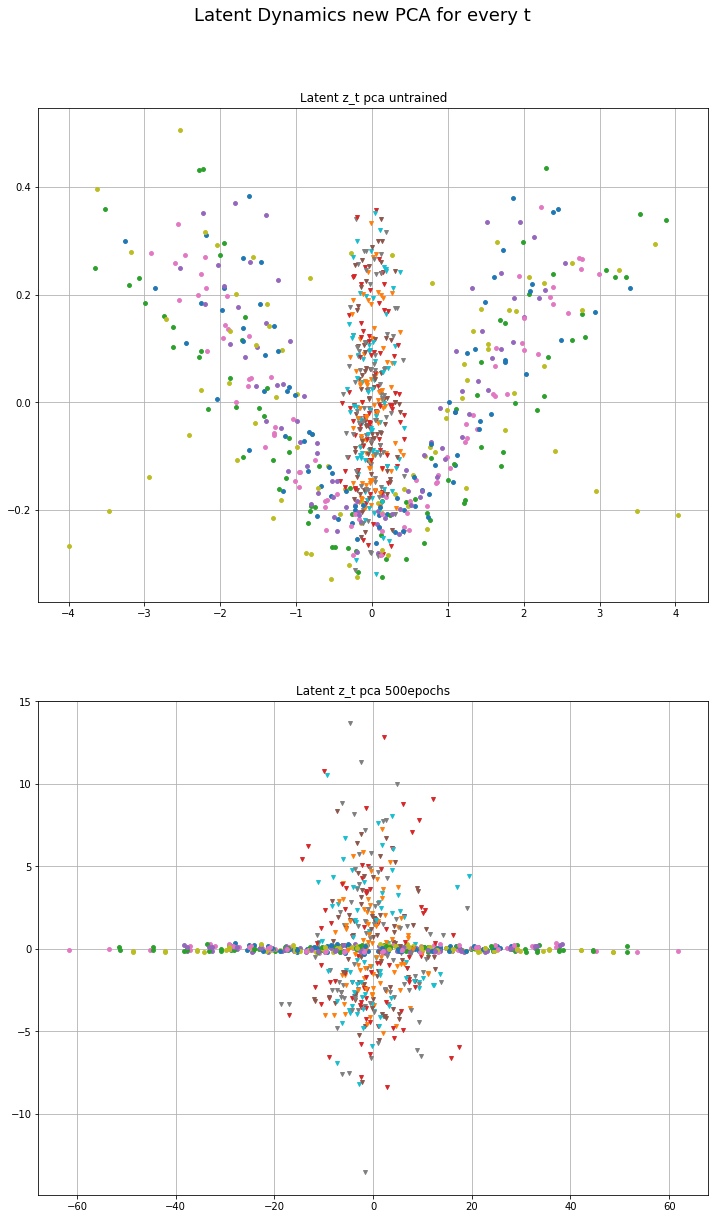

In [141]:
# create subplots
names = ['untrained', '500epochs']
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(12, 20))
fig.suptitle("Latent Dynamics new PCA for every t", fontsize=18, y=0.95)
with torch.set_grad_enabled(False):
    for n in range(N):
        for i, data_z in zip(range(2), ((ode_zt, enc_base_zt), (ode_500_zt,enc_500_zt))):
            ode, enc = data_z
            ode_pca = pca.fit_transform(ode[n]) # T,2
            enc_pca = pca.fit_transform(enc[n]) # T,2
            
            axs[i].scatter(ode_pca[:,0],ode_pca[:,1], s = 15, zorder=2.5, marker ='o')
            axs[i].scatter(enc_pca[:,0], enc_pca[:,1], s = 15, zorder=2.5, marker = 'v')            
            axs[i].set_title('Latent z_t pca ' + names[i])
            axs[i].grid()


plt.show()

### Option 2B: Fit an initial pca t=0, and reuse for all t 

In [142]:
dict_pca_zt = {}
with torch.set_grad_enabled(False): 
    for n, data_zt in zip(range(2), ((ode_zt, enc_base_zt), (ode_500_zt,enc_500_zt))):
        ode_zt, enc_zt = data_zt
        dict_pca_zt['pca_{}_zt'.format(n)] = PCA(n_components=2).fit(ode_zt[:,0])
        dict_pca_zt['pca_{}__enc_zt'.format(n)] = PCA(n_components=2).fit(enc_zt[:,0])


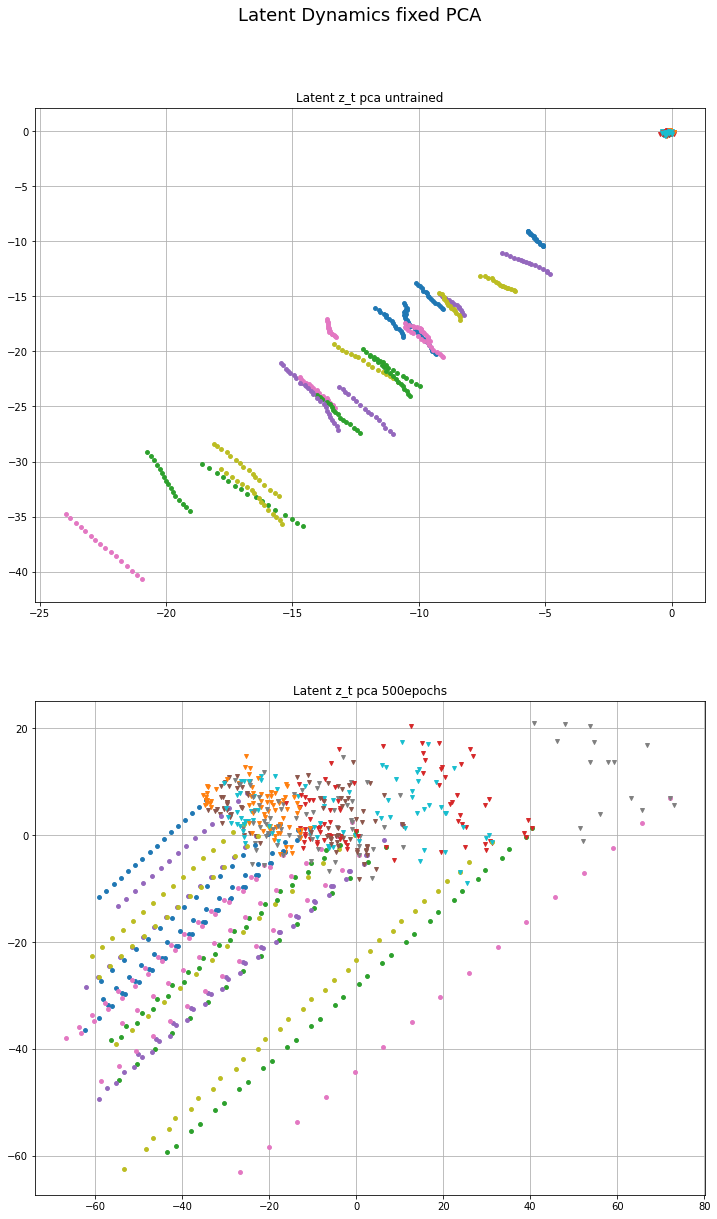

In [143]:
# create subplots
names = ['untrained', '500epochs']
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(12, 20))
fig.suptitle("Latent Dynamics fixed PCA", fontsize=18, y=0.95)
with torch.set_grad_enabled(False):
    for n in range(N):
        for i, data_z in zip(range(2), ((ode_zt, enc_base_zt), (ode_500_zt,enc_500_zt))):
            ode, enc = data_z
            ode_pca = dict_pca_zt['pca_{}_zt'.format(i)].transform(ode[n]) # T,2
            enc_pca = dict_pca_zt['pca_{}_zt'.format(i)].transform(enc[n]) # T,2
            
            axs[i].scatter(ode_pca[:,0],ode_pca[:,1], s = 15, zorder=2.5, marker = 'o')
            axs[i].scatter(enc_pca[:,0], enc_pca[:,1], s = 15, zorder=2.5, marker = 'v')            
            axs[i].set_title('Latent z_t pca ' + names[i])
            axs[i].grid()

plt.show()